In [1]:
setwd("/Users/amyvandiver/Box/Nanopore/Timp_data")

In [2]:
library(GenomicRanges)
library(GenomicAlignments)
library(ggbio)
library(ggplot2)
library(gridExtra)

Warning message:
“package ‘GenomicRanges’ was built under R version 4.0.3”
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.0.3”
Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort

In [3]:
#Load mito annotation file, put into GRanges to prep for plotting

locs=read.csv("/Users/amyvandiver/Box/Nanopore/mitogenes.csv")
gr= GRanges(seqnames=rep("M",nrow(locs)), IRanges(start=locs$Start,end=locs$End),strand=rep('*',nrow(locs)),name=locs$Name,type=locs$Type,complex=locs$Complex)
gr$names1=gr$name
gr$names1[which(gr$type=="tRNA")]=NA
gr$names1[which(gr$type=="D-Loop")]=NA
gr$names1[which(gr$name=="ATP8")]=NA
gr$names1[which(gr$name=="ATP6")]="ATP8-ATP6"

seqlengths(gr)<-("M"=max(end(gr)))


In [4]:
#load nanopore alignments
all<- readGAlignments("GM12878/190115_cas9enrich_mito1_multif5.gup5.rotM.bam")


[1] 0.6588691

[1] 142907

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     47    7943   16456   12593   16544  113508 

[1] 16541

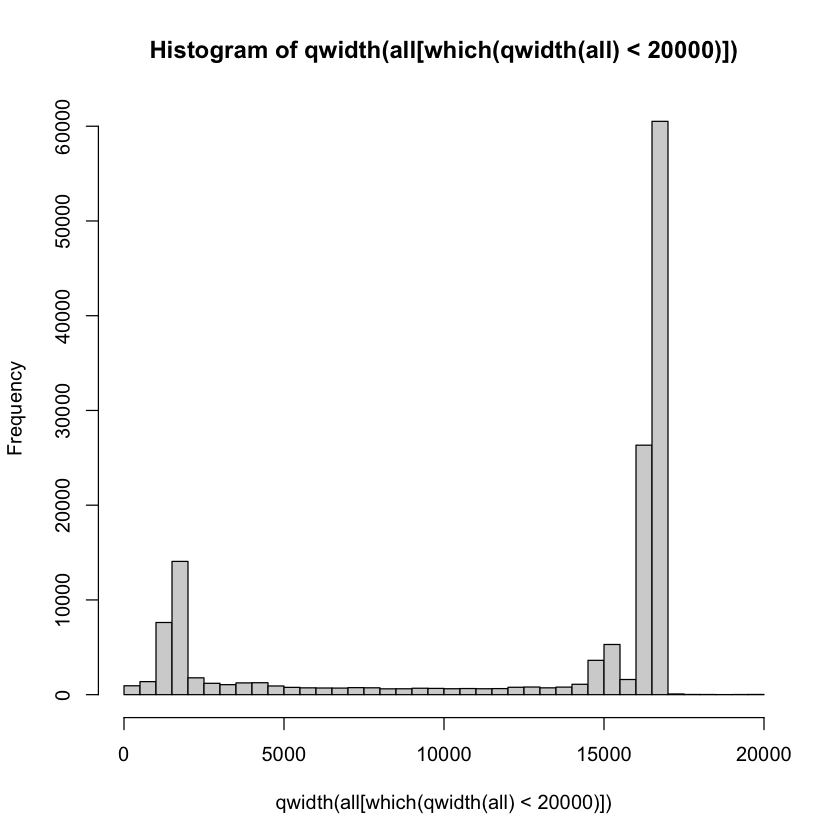

In [5]:
#descriptive stats of chrM_rot alignments
length(which(qwidth(all)>15000))/length(all)

length(all)

hist(qwidth(all[which(qwidth(all)<20000)]),breaks=30)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

summary(qwidth(all))
getmode(qwidth(all))

In [6]:
summary(qwidth(all))
getmode(qwidth(all))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     47    7943   16456   12593   16544  113508 

[1] 16541

In [7]:
#look at reads near 1500 bp, how many start at bp 66?
length(which(qwidth(all)>1450 & qwidth(all)<1550))/length(all)
sub=all[which(qwidth(all)>1450 & qwidth(all)<1550)]
length(which(start(sub)>15077 & start(sub)<15097))/length(sub) 


[1] 0.1065658

[1] 0.8354455

In [13]:
#plot histogram of ChrM sizes
pdf("GM12878/ChrM lengths.pdf")
hist(qwidth(all),breaks=150,xlim=c(0,20000),col="blue",xlab="Read Lengths",main="mtDNA read lengths")
abline(v=16569,lty=2)
dev.off()

pdf 
  2

In [11]:
#Load forward and reverse bams, make to density format for coverage plots
fr<- readGAlignments("forward_rot.bam")
rr<- readGAlignments("rev_rot.bam")

frcov<-coverage(fr)
frnum<- as.numeric(frcov$chrM)

rrcov<-coverage(rr)
rrnum<- as.numeric(rrcov$chrM)


In [13]:
#Covert annotation file to rotated genome

locs$col=as.numeric(as.factor(locs$Type))+1

temp=locs[which(locs$Start<1547 & locs$End>1547),]
temp[2,]=temp[1,]
temp[1,"End"]=1547
temp[2,"Start"]=1548
locs2=rbind(locs[-which(locs$Start<1547 & locs$End>1547),],temp)
locs2$Start[which(locs2$Start<1548)]=locs2$Start[which(locs2$Start<1548)]+16569
locs2$End[which(locs2$End<1548)]=locs2$End[which(locs2$End<1548)]+16569

locs2$Start[which(locs2$Start>1547)]=locs2$Start[which(locs2$Start>1547)]-1547
locs2$End[which(locs2$End>1547)]=locs2$End[which(locs2$End>1547)]-1547

locs2$center=(locs2$Start+locs2$End)/2

In [15]:
#make snp density annotation from mitomap annotation
snps=read.csv("marker_finder.csv")

snps2=snps
snps2$Position[which(snps2$Position%in%c(1:1547))]=snps2$Position[which(snps2$Position%in%c(1:1547))]+16569
snps2$Position=snps2$Position-1547
colnames(snps2)[6]="Freq"
snps2$Freq=as.numeric(gsub("%","",snps2$Freq))


In [25]:
#plot density, snps and annotation on rotated coordinates 
pdf("Coverage_test_rot.pdf",width=14,height=4)
par(cex=0.8, mai=c(0.05,0.05,0.1,0.1))
par(fig=c(0.1,0.9,0.5,0.9))
plot(frnum, type="l", col="blue", lwd=4, xlab="",xaxt="n",ylab="Sequencing Depth")
lines(rrnum, col="red", lwd=4)
legend(15500, 85000, legend=c("Foward", "Reverse"),
       col=c("blue", "red"), lty=1,lwd=2, cex=1, box.lty=0)

par(fig=c(0.1,0.9,0.35,0.51),new=TRUE)

plot(c(0,length(rrcov$chrM)),c(0,100),type="n",ylab="",xlab="Location on ChrM",yaxt="n",xaxt="n")
lines(snps2$Freq~snps2$Position, col="black")

par(fig=c(0.1,0.9,0.2,0.35), new=TRUE)
plot(c(0,length(rrcov$chrM)),c(0,50),type="n",ylab="",xlab="Location on ChrM",yaxt="n",xaxt="n")
axis(1, at = c(0,3453,8453,13453,15022), labels = c("cut site",5000,10000,15000,0))

for (i in 1:(nrow(locs2))){
rect(locs2$Start[i],0,locs2$End[i],50,col=locs2$col[i])
}


dev.off()

pdf 
  2

In [26]:
library(data.table)




Attaching package: 'data.table'


The following objects are masked from 'package:GenomicAlignments':

    first, last, second


The following object is masked from 'package:SummarizedExperiment':

    shift


The following object is masked from 'package:GenomicRanges':

    shift


The following object is masked from 'package:IRanges':

    shift


The following objects are masked from 'package:S4Vectors':

    first, second




In [27]:
#load GIAB variant file to plot SNPs

vcf=fread("fb/HG001_ChrM_rot.calls.filt.vcf")

#calculate percantage of variant
vcf$RO=as.numeric(unlist(tstrsplit(vcf$unknown,":")[4]))
vcf$AO=as.numeric(unlist(tstrsplit(vcf$unknown,":")[6]))
vcf$perA=round(vcf$AO/(vcf$AO+vcf$RO),2)

illum<- readGAlignments("illumina/HG001_ChrM_rot.bam")

covill=coverage(illum)

cinum=as.numeric(covill$chrM)
x=seq(1:length(cinum))

In [35]:
#load nanopore variant file to plot SNPs
vcf1=fread("bcftools/190115_cas9enrich_chrM_rot.bcfcall.vcf")

colnames(vcf1)[10]="freq"
AD=unlist(tstrsplit(vcf1$freq,":")[5])
ref=as.numeric(unlist(tstrsplit(AD,",")[1]))
alt=as.numeric(unlist(tstrsplit(AD,",")[2]))
vcf1$perA=alt/(ref+alt)

nano<- readGAlignments("GM12878/190115_cas9enrich_mito1_multif5.gup5.rotM.bam")

covnan=coverage(nano)

cnnum=as.numeric(covnan$chrM)
x1=seq(1:length(cnnum))

In [46]:
#plot both snp files together
pdf("GM12878/Nano_Illum_snps.pdf",width=14, height=4)
par(cex=0.8, mai=c(0.05,0.05,0.1,0.1))
par(fig=c(0.1,0.9,0.5,0.85))

plot(cinum, type="l", col="grey90", lwd=4, xlab="Location on ChrM",ylab="Sequencing Depth",ylim=c(0,max(cinum)),xaxt="n")

polygon(c(x, 16569, 0), c(cinum, 0, 0), col="grey90",border=NA)
text(2, 100000, "Illumina",pos = 2, srt = 90)
for (i in 1:(nrow(vcf))){
    if(vcf$perA[i]>0.9){
        if(vcf$ALT[i]=="C"){
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]],border="blue")
        }
        else if(vcf$ALT[i]=="T"){
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]],border="red")
        }
        else if(vcf$ALT[i]=="G"){
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]],border="tan2")
        }
        else if(vcf$ALT[i]=="A"){
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]],border="darkgreen")
        }
    }        
    else{
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]]*vcf$perA[i],border="darkgreen")
        rect(vcf$POS[i],(cinum[vcf$POS[i]]*vcf$perA[i]),vcf$POS[i],cinum[vcf$POS[i]],border="tan2")
    }
    }
    
par(fig=c(0.1,0.9,0.1,0.45),new=TRUE)
plot(cnnum, type="l", col="grey90", lwd=4, xlab="Location on ChrM",ylab="Sequencing Depth",ylim=c(0,max(cnnum)),xaxt="n")
axis(1, at = c(0,3453,8453,13453,15022), labels = c("cut site",5000,10000,15000,0))
polygon(c(x1, 16569, 0), c(cnnum, 0, 0), col="grey90",border=NA)
text(2, 80000, "Nanopore",pos = 2, srt = 90)
for (i in 1:(nrow(vcf1))){
    if(vcf1$perA[i]>0.9){
        if(vcf1$ALT[i]=="C"){
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]],border="blue")
        }
        else if(vcf1$ALT[i]=="T"){
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]],border="red")
        }
        else if(vcf1$ALT[i]=="G"){
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]],border="tan2")
        }
        else if(vcf1$ALT[i]=="A"){
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]],border="darkgreen")
        }
    }        
    else{
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]]*vcf1$perA[i],border="darkgreen")
        rect(vcf1$POS[i],(cnnum[vcf1$POS[i]]*vcf1$perA[i]),vcf1$POS[i],cnnum[vcf1$POS[i]],border="tan2")
    }
    }
    
    dev.off()

pdf 
  2

ERROR: Error in if (vcf1$perA[i] > 0.9) {: missing value where TRUE/FALSE needed


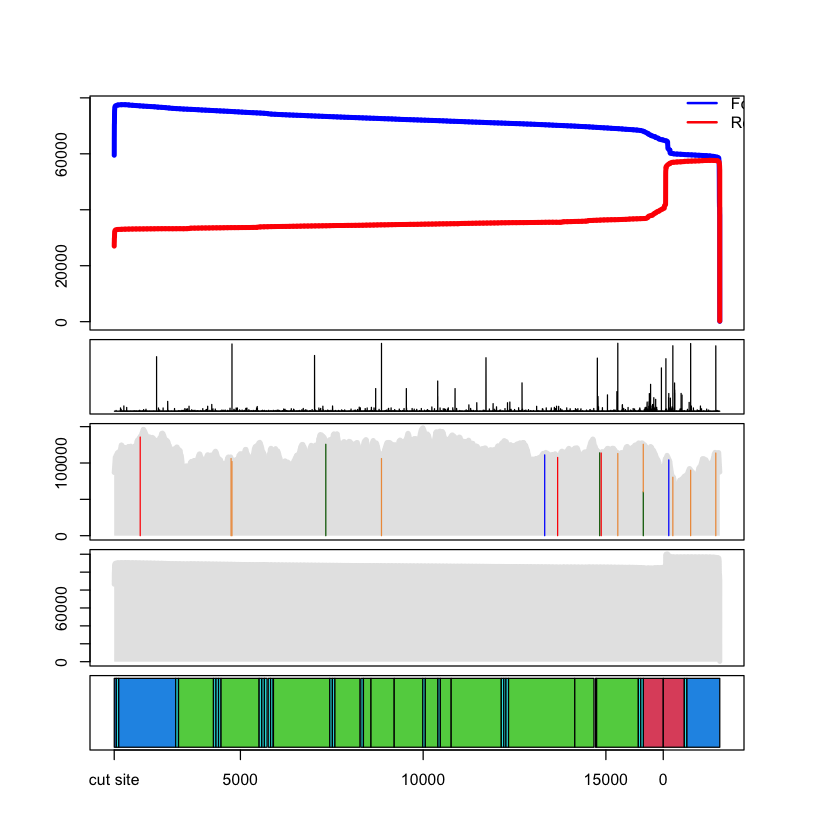

In [34]:
#pdf("Super_fig_1.pdf",width=12,height=5)

par(cex=0.8, mai=c(0.05,0.05,0.1,0.1))

#Coverage plot
par(fig=c(0.1,0.9,0.6,0.9))
plot(frnum, type="l", col="blue", lwd=4, xlab="",xaxt="n",ylab="Sequencing Depth")
lines(rrnum, col="red", lwd=4)
legend(15300, 85000, legend=c("Foward", "Reverse"),
       col=c("blue", "red"), lty=1,lwd=2, cex=1, box.lty=0)

#Snp density plot
par(fig=c(0.1,0.9,0.5,0.61),new=TRUE)
plot(c(0,length(rrcov$chrM)),c(0,100),type="n",ylab="",xlab="Location on ChrM",yaxt="n",xaxt="n")
lines(snps2$Freq~snps2$Position, col="black")

#bottom mito layout plot
par(fig=c(0.1,0.9,0.1,0.21), new=TRUE)
plot(c(0,length(rrcov$chrM)),c(0,50),type="n",ylab="",xlab="Location on ChrM",yaxt="n",xaxt="n")
axis(1, at = c(0,3453,8453,13453,15022), labels = c("cut site",5000,10000,15000,0))
for (i in 1:(nrow(locs2))){
rect(locs2$Start[i],0,locs2$End[i],50,col=locs2$col[i])
}

#snps in illumina
par(fig=c(0.1,0.9,0.35,0.51),new=TRUE)
plot(cinum, type="l", col="grey90", lwd=4, xlab="",ylab="Sequencing Depth",ylim=c(0,max(cinum)),xaxt="n")
polygon(c(x, 16569, 0), c(cinum, 0, 0), col="grey90",border=NA)
for (i in 1:(nrow(vcf))){
    if(vcf$perA[i]>0.9){
        if(vcf$ALT[i]=="C"){
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]],border="blue")
        }
        else if(vcf$ALT[i]=="T"){
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]],border="red")
        }
        else if(vcf$ALT[i]=="G"){
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]],border="tan2")
        }
        else if(vcf$ALT[i]=="A"){
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]],border="darkgreen")
        }
    }        
    else{
        rect(vcf$POS[i],0,vcf$POS[i],cinum[vcf$POS[i]]*vcf$perA[i],border="darkgreen")
        rect(vcf$POS[i],(cinum[vcf$POS[i]]*vcf$perA[i]),vcf$POS[i],cinum[vcf$POS[i]],border="tan2")
    }
    }

#snps in nanopore
par(fig=c(0.1,0.9,0.2,0.36),new=TRUE)
plot(cnnum, type="l", col="grey90", lwd=4, xlab="",ylab="Sequencing Depth",ylim=c(0,max(cnnum)),xaxt="n")
polygon(c(x1, 16569, 0), c(cnnum, 0, 0), col="grey90",border=NA)
for (i in 1:(nrow(vcf1))){
    if(vcf1$perA[i]>0.9){
        if(vcf1$ALT[i]=="C"){
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]],border="blue")
        }
        else if(vcf1$ALT[i]=="T"){
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]],border="red")
        }
        else if(vcf1$ALT[i]=="G"){
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]],border="tan2")
        }
        else if(vcf1$ALT[i]=="A"){
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]],border="darkgreen")
        }
    }        
    else{
        rect(vcf1$POS[i],0,vcf1$POS[i],cnnum[vcf1$POS[i]]*vcf1$perA[i],border="darkgreen")
        rect(vcf1$POS[i],(cnnum[vcf1$POS[i]]*vcf1$perA[i]),vcf1$POS[i],cnnum[vcf1$POS[i]],border="tan2")
    }
    }

#dev.off()